# American Sign Language Detection

The [American Sign Language alphabet](http://www.asl.gs/) contains 26 letters. Two of those letters (j and z) require movement, so they are not included in the training dataset.
The main objectives are:
* Use Data Augmentation on the ASL dataset
* Use the augmented data to train an improved model based on CNN
* Predict on real-life images.

### Download Training and Validation Data

In [ ]:
import gdown 

!gdown --id 1QF_fZ0xt86kmN3XMo-B7I8SUPZPMH3RR
!unzip asl_data.zip

Downloading...
From: https://drive.google.com/uc?id=1QF_fZ0xt86kmN3XMo-B7I8SUPZPMH3RR
To: /content/asl_data.zip
30.8MB [00:01, 28.9MB/s]
Archive:  asl_data.zip
Created by ZIP Extractor v4.25 on 2021-06-27
  inflating: asl_data/sign_mnist_train.csv  
  inflating: asl_data/sign_mnist_valid.csv  


## Preparing the Data

In [ ]:
import tensorflow.keras as keras
import pandas as pd

# Load in our data from CSV files
train_df = pd.read_csv("./asl_data/sign_mnist_train.csv")
valid_df = pd.read_csv("./asl_data/sign_mnist_valid.csv")

# Separate out our target values
y_train = train_df['label']
y_valid = valid_df['label']
del train_df['label']
del valid_df['label']

# Separate our our image vectors
x_train = train_df.values
x_valid = valid_df.values

# Turn our scalar targets into binary categories
num_classes = 24
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# Normalize our image data
x_train = x_train / 255
x_valid = x_valid / 255

# Reshape the image data for the convolutional network
x_train = x_train.reshape(-1,28,28,1)
x_valid = x_valid.reshape(-1,28,28,1)

## Model Creation

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 75)        750       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 75)        300       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 75)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        33800     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 50)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 50)        200       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)          0

## Data Augmentation

We want to flip images horizontally, but not vertically. Dataset is pictures of hands signing the alphabet. If we want to use this model to classify hand images later, it's unlikely that those hands are going to be upside-down, but, they might be left-handed. 

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False, # Don't randomly flip images vertically
)  

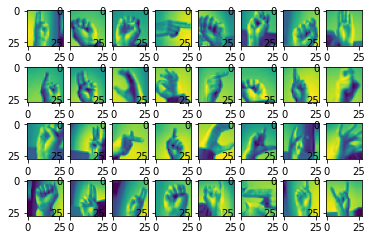

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
batch_size = 32
img_iter = datagen.flow(x_train, y_train, batch_size=batch_size)

x, y = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

## Fitting the Data to the Generator

In [ ]:
datagen.fit(x_train)
print(x_train.shape)

(27455, 28, 28, 1)


## Compiling the Model

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

## Training with Augmentation

In [ ]:
model.fit(img_iter,
          epochs=20,
          steps_per_epoch=len(x_train)/batch_size, # Run same number of steps we would if we were not using a generator.
          validation_data=(x_valid, y_valid))

Epoch 1/20
857/857 [==============================] - 42s 12ms/step - loss: 1.1142 - accuracy: 0.6407 - val_loss: 0.3682 - val_accuracy: 0.8595
Epoch 2/20
857/857 [==============================] - 10s 12ms/step - loss: 0.3287 - accuracy: 0.8873 - val_loss: 1.7922 - val_accuracy: 0.5940
Epoch 3/20
857/857 [==============================] - 10s 12ms/step - loss: 0.2003 - accuracy: 0.9333 - val_loss: 0.1111 - val_accuracy: 0.9624
Epoch 4/20
857/857 [==============================] - 10s 12ms/step - loss: 0.1526 - accuracy: 0.9501 - val_loss: 0.1007 - val_accuracy: 0.9632
Epoch 5/20
857/857 [==============================] - 11s 13ms/step - loss: 0.1261 - accuracy: 0.9594 - val_loss: 0.1163 - val_accuracy: 0.9605
Epoch 6/20
857/857 [==============================] - 11s 12ms/step - loss: 0.1077 - accuracy: 0.9653 - val_loss: 0.1111 - val_accuracy: 0.9685
Epoch 7/20
857/857 [==============================] - 11s 13ms/step - loss: 0.1026 - accuracy: 0.9663 - val_loss: 0.1283 - val_accuracy:

In [ ]:
model.save('asl_model')

INFO:tensorflow:Assets written to: asl_model/assets


In [ ]:
from tensorflow import keras

model = keras.models.load_model('asl_model')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image, cmap='gray')

### Scaling the Images

The images in our dataset were 28x28 pixels and grayscale. We need to make sure to pass the same size and grayscale images into our method for prediction

In [ ]:
from tensorflow.keras.preprocessing import image as image_utils

def load_and_scale_image(image_path):
    image = image_utils.load_img(image_path, color_mode="grayscale", target_size=(28,28))
    return image

In [ ]:
# Alphabet does not contain j or z because they require movement
alphabet = "abcdefghiklmnopqrstuvwxy"
dictionary = {}
for i in range(24):
    dictionary[i] = alphabet[i]
dictionary

{0: 'a',
 1: 'b',
 2: 'c',
 3: 'd',
 4: 'e',
 5: 'f',
 6: 'g',
 7: 'h',
 8: 'i',
 9: 'k',
 10: 'l',
 11: 'm',
 12: 'n',
 13: 'o',
 14: 'p',
 15: 'q',
 16: 'r',
 17: 's',
 18: 't',
 19: 'u',
 20: 'v',
 21: 'w',
 22: 'x',
 23: 'y'}

###Predict the letter from raw predictions

In [ ]:
import numpy as np

def predict_letter(file_path):
    show_image(file_path)
    image = load_and_scale_image(file_path)
    image = image_utils.img_to_array(image)
    image = image.reshape(1,28,28,1)
    image = image / 255
    prediction = model.predict(image)
    predicted_letter = dictionary[np.argmax(prediction)]
    return predicted_letter 

### Upload a test image

In [ ]:
#Try how the model predicts for an unseen image. Provide path to the image you want to predict

image=input()

/content/asl_data/a.png


'a'

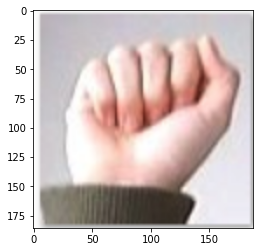

In [ ]:
predict_letter(image)